In [10]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

import datetime
from dateutil import parser


import re
import spacy

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer

# Display setting to show more characters in column
pd.set_option('display.max_columns', 500)

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

### Load data


In [11]:
df = pd.read_csv(r"data/v1_full.csv").sample(1000)


### Cleaning dataset


##### -date format tranformation


In [12]:
def change_type(dates):
    column = []

    for date in dates:
        column.append(parser.parse(date).strftime("%d-%m-%Y %H:%M:%S"))
    return column


df["date"] = change_type(df["date"])
df.head(1)


,id_mail,date,from,to,subject,body,x_origin
39087,<26496401.1075849289243.JavaMail.evans@thyme>,26-06-2001 11:15:00,jeff.dasovich@enron.com,james.steffes@enron.com,Re: Senate Energy,no. call me. 415.505.6633.\n\njeff,DASOVICH-J


##### - Missing values


In [13]:
df.isnull().sum()


id_mail      0
date         0
from         0
to          30
subject     37
body         0
x_origin     0
dtype: int64

In [14]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub("\S*@\S*\s?", "", sent)  # remove emails
        sent = re.sub("\s+", " ", sent)  # remove newline chars
        sent = re.sub("'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield (sent)


data = df.body.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])


[['no', 'call', 'me', 'jeff']]


In [27]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(
    texts, stop_words=stop_words, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]
):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [
        [word for word in simple_preprocess(str(doc)) if word not in stop_words]
        for doc in texts
    ]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append(
            [token.lemma_ for token in doc if token.pos_ in allowed_postags]
        )
    # remove stopwords once more after lemmatization
    texts_out = [
        [word for word in simple_preprocess(str(doc)) if word not in stop_words]
        for doc in texts_out
    ]
    return texts_out


data_ready = process_words(data_words)


### LDA


In [28]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=4,
    random_state=100,
    update_every=1,
    chunksize=10,
    passes=10,
    alpha="symmetric",
    iterations=100,
    per_word_topics=True,
)

print(lda_model.print_topics())


[(0, '0.023*"deal" + 0.020*"know" + 0.013*"let" + 0.012*"get" + 0.012*"go" + 0.011*"make" + 0.011*"thank" + 0.010*"number" + 0.010*"give" + 0.010*"think"'), (1, '0.022*"mail" + 0.021*"send" + 0.020*"com" + 0.012*"round" + 0.008*"school" + 0.008*"draft" + 0.007*"letter" + 0.006*"back" + 0.006*"hope" + 0.006*"get"'), (2, '0.012*"request" + 0.012*"forward" + 0.011*"agreement" + 0.010*"pm" + 0.010*"information" + 0.009*"question" + 0.008*"thank" + 0.008*"include" + 0.008*"contact" + 0.008*"follow"'), (3, '0.018*"say" + 0.015*"company" + 0.013*"energy" + 0.013*"market" + 0.010*"power" + 0.009*"state" + 0.007*"business" + 0.007*"price" + 0.006*"year" + 0.006*"fund"')]


# Topic


In [29]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()

    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]),
                    ignore_index=True,
                )
            else:
                break
    sent_topics_df.columns = ["Dominant_Topic", "Perc_Contribution", "Topic_Keywords"]

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df


df_topic_sents_keywords = format_topics_sentences(
    ldamodel=lda_model, corpus=corpus, texts=data_ready
)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
    "Document_No",
    "Dominant_Topic",
    "Topic_Perc_Contrib",
    "Keywords",
    "Text",
]
df_dominant_topic.head(10)


/var/folders/f_/lq61lr8515sdgzbg0slfc_5c0000gn/T/ipykernel_11030/1628875013.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/f_/lq61lr8515sdgzbg0slfc_5c0000gn/T/ipykernel_11030/1628875013.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.6250,"mail, send, com, round, school, draft, letter,...",[jeff]
1,1,1,0.9944,"mail, send, com, round, school, draft, letter,...","[forward, randall, gay, shulklapper, randall, ..."
2,2,0,0.5643,"deal, know, let, get, go, make, thank, number,...","[gang, well, crunch, number, day, yet, get, wr..."
3,3,1,0.7214,"mail, send, com, round, school, draft, letter,...","[forward, lorraine, love, forward, send, love,..."
4,4,1,0.5864,"mail, send, com, round, school, draft, letter,...","[receive, com, follow, address, permanent, fat..."
5,5,0,0.7124,"deal, know, let, get, go, make, thank, number,...","[let, know, think, also, check, volume, ena, b..."
6,6,2,0.4865,"request, forward, agreement, pm, information, ...","[forward, hou_ect, pm, vera, research, develop..."
7,7,2,0.5253,"request, forward, agreement, pm, information, ...","[migrating, et, quickplace, server, maintenanc..."
8,8,3,0.7944,"say, company, energy, market, power, state, bu...","[see, follow, article, sac_bee, lawmaker, deba..."
9,9,0,0.7024,"deal, know, let, get, go, make, thank, number,...","[cas, see, deal, rating, protest, week, ill, f..."


# Cluster

In [32]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby("Dominant_Topic")

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat(
        [
            sent_topics_sorteddf_mallet,
            grp.sort_values(["Perc_Contribution"], ascending=False).head(1),
        ],
        axis=0,
    )

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = [
    "Topic_Num",
    "Topic_Perc_Contrib",
    "Keywords",
    "Representative Text",
]

# Show
sent_topics_sorteddf_mallet.head()


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9854,"deal, know, let, get, go, make, thank, number,...","[hour, hourahead, schedule, download, fail, ma..."
1,1,0.9944,"mail, send, com, round, school, draft, letter,...","[forward, randall, gay, shulklapper, randall, ..."
2,2,0.9726,"request, forward, agreement, pm, information, ...","[receive, email, list, datum, approver, click,..."
3,3,0.8894,"say, company, energy, market, power, state, bu...","[take, action, help, high, electricity, price]"


### Top modeling visualization


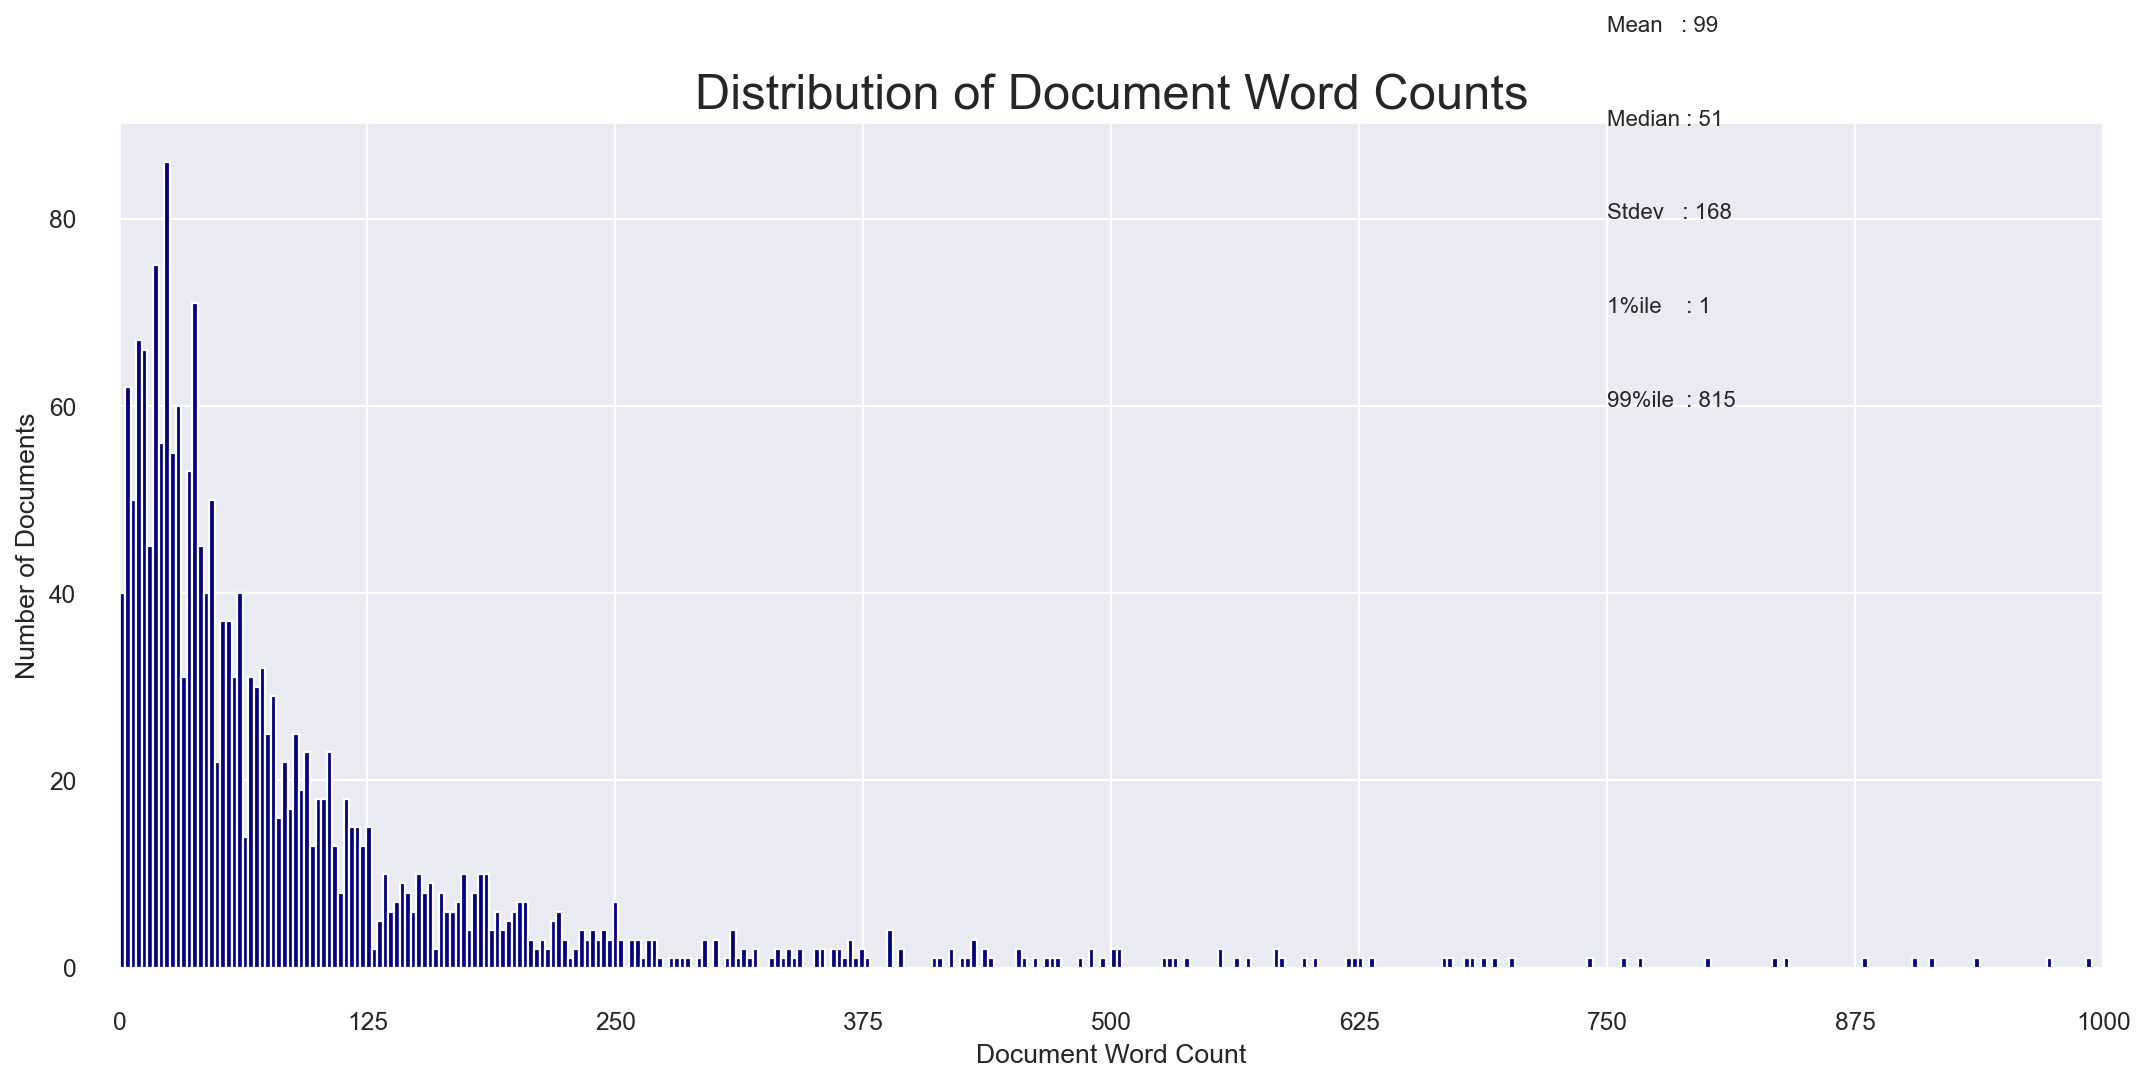

In [40]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16, 7), dpi=160)
plt.hist(doc_lens, bins=1000, color="navy")
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750, 90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750, 80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750, 70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750, 60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(
    xlim=(0, 1000), ylabel="Number of Documents", xlabel="Document Word Count"
)
plt.tick_params(size=16)
plt.xticks(np.linspace(0, 1000, 9))
plt.title("Distribution of Document Word Counts", fontdict=dict(size=22))
plt.show()


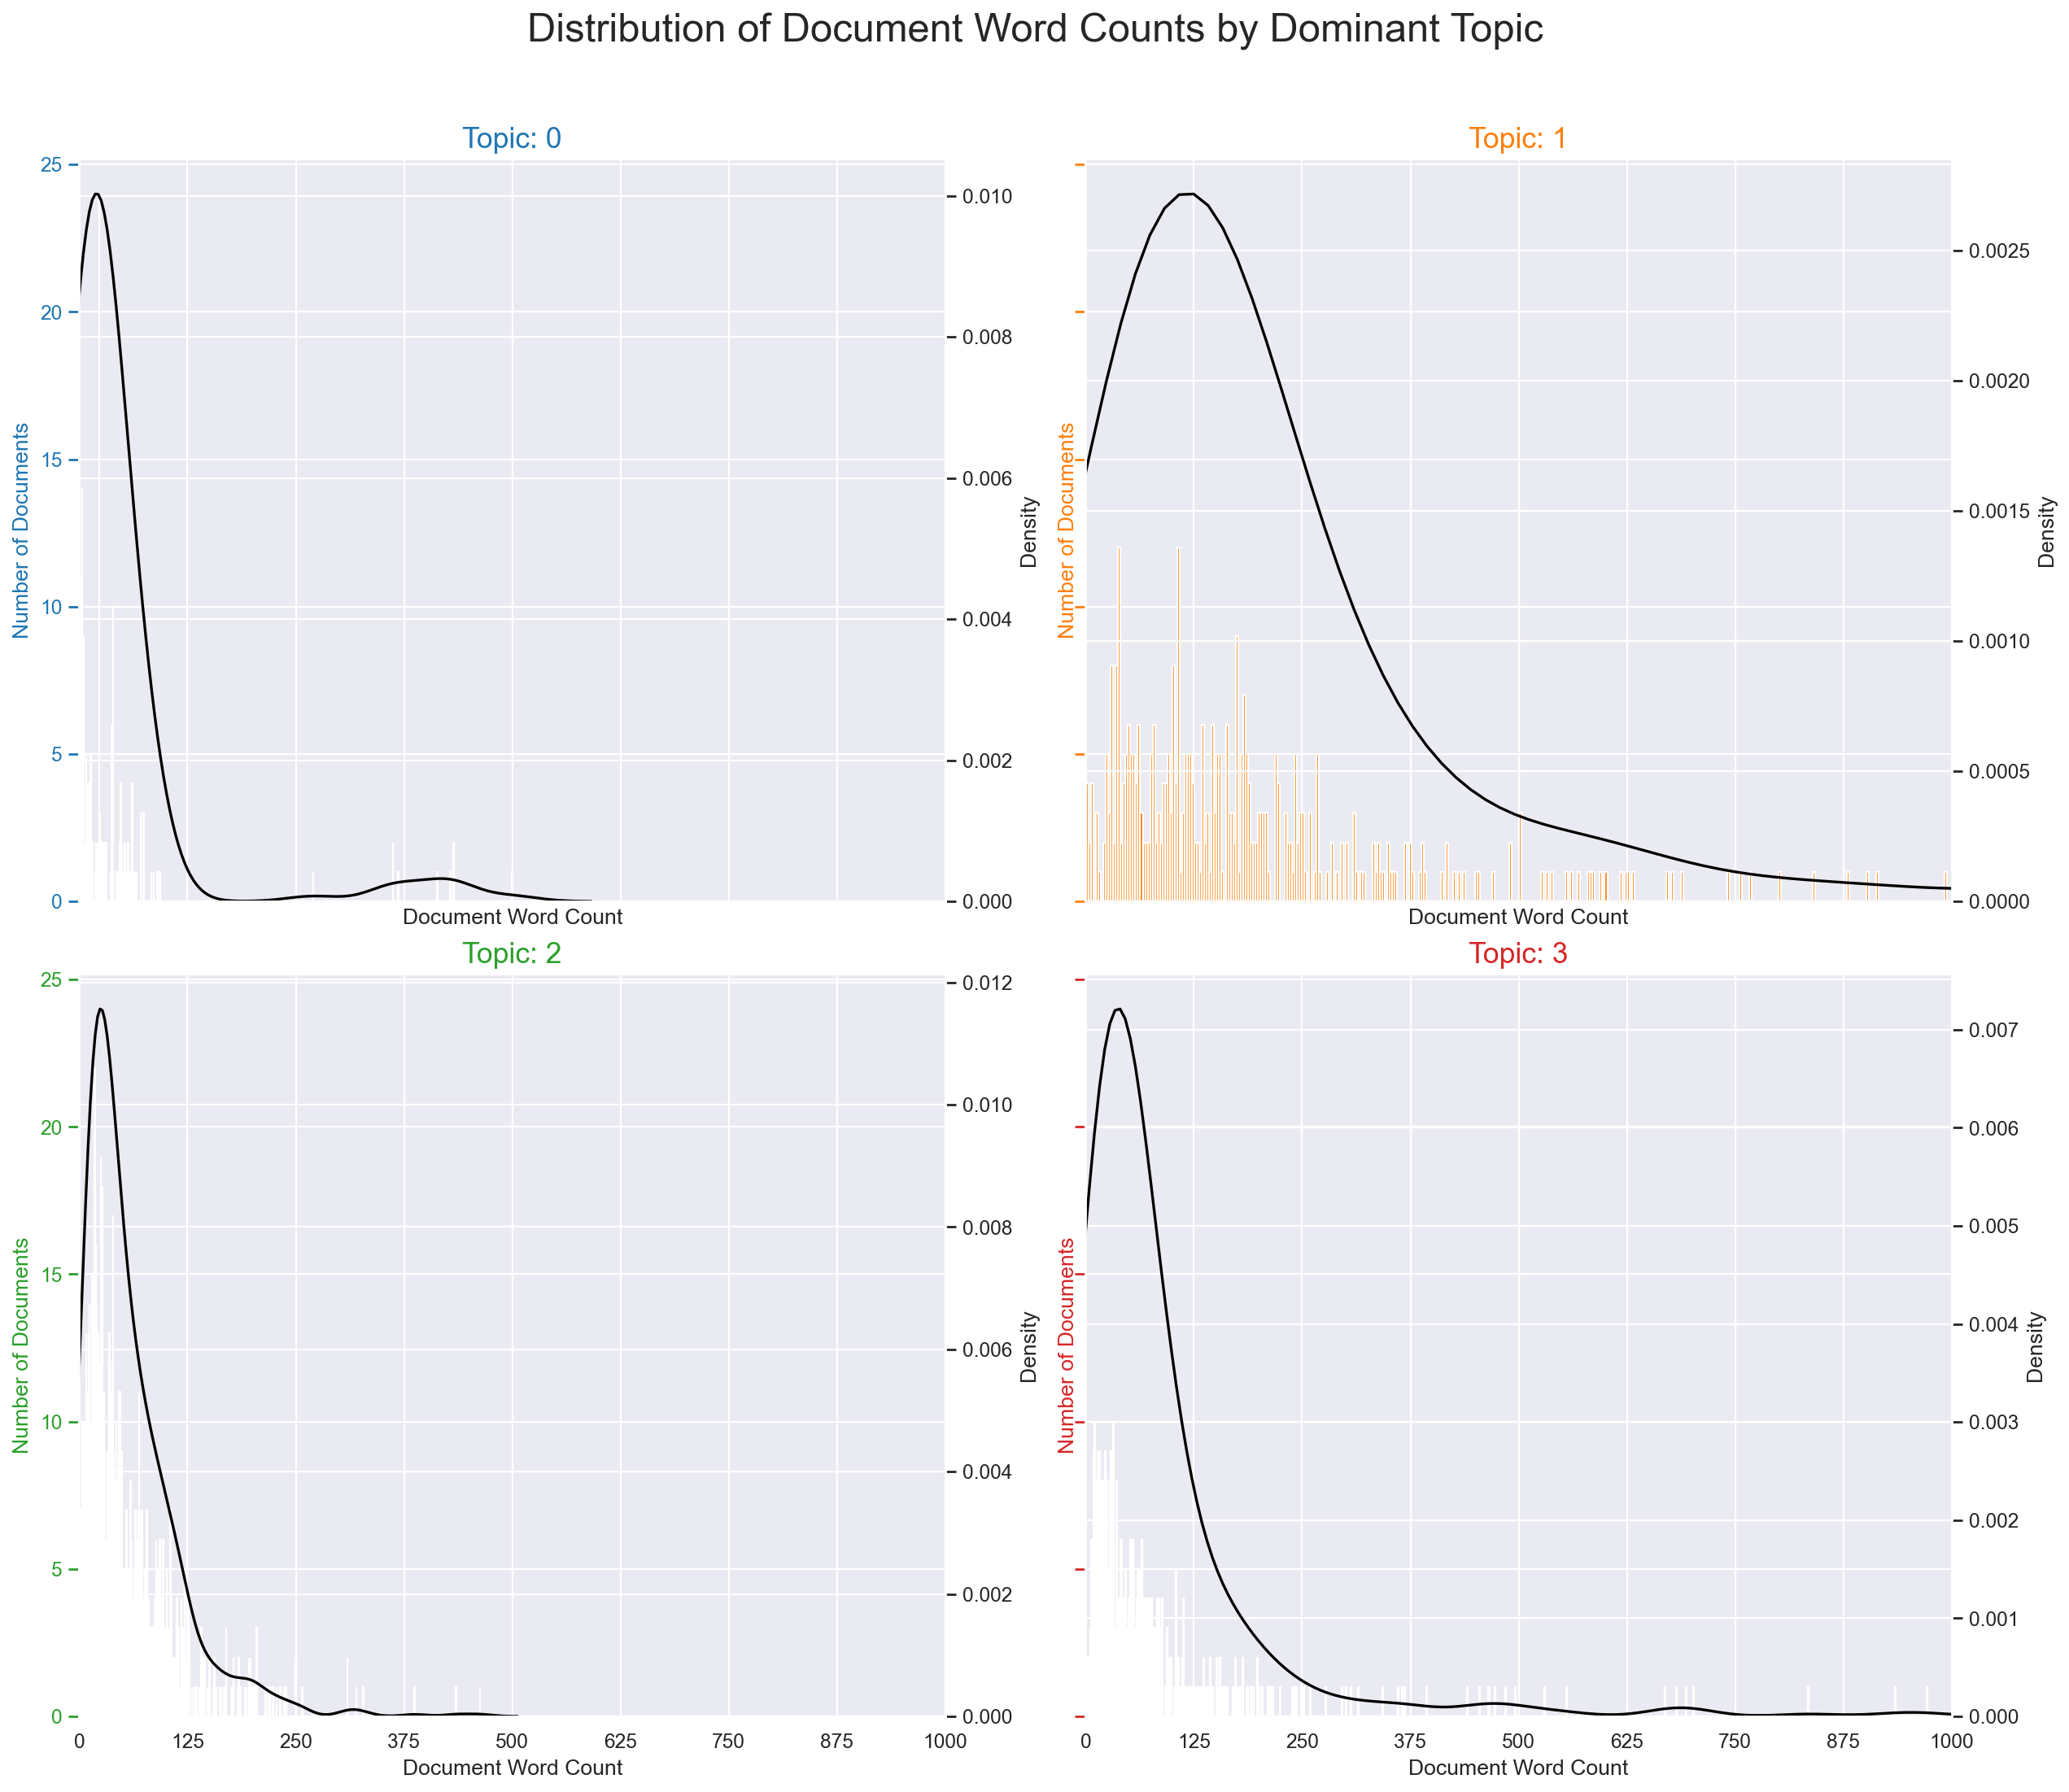

In [41]:
import seaborn as sns
import matplotlib.colors as mcolors

cols = [
    color for name, color in mcolors.TABLEAU_COLORS.items()
]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2, 2, figsize=(16, 14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    df_dominant_topic_sub = df_dominant_topic.loc[
        df_dominant_topic.Dominant_Topic == i, :
    ]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins=1000, color=cols[i])
    ax.tick_params(axis="y", labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel="Document Word Count")
    ax.set_ylabel("Number of Documents", color=cols[i])
    ax.set_title("Topic: " + str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0, 1000, 9))
fig.suptitle("Distribution of Document Word Counts by Dominant Topic", fontsize=22)
plt.show()


In [43]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [
    color for name, color in mcolors.TABLEAU_COLORS.items()
]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
    stopwords=stop_words,
    background_color="white",
    width=2500,
    height=1800,
    max_words=10,
    colormap="tab10",
    color_func=lambda *args, **kwargs: cols[i],
    prefer_horizontal=1.0,
)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title("Topic " + str(i), fontdict=dict(size=16))
    plt.gca().axis("off")


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis("off")
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'wordcloud'

C:\Users\sayra\AppData\Local\Temp\ipykernel_5312\2855870167.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\sayra\AppData\Local\Temp\ipykernel_5312\2855870167.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\sayra\AppData\Local\Temp\ipykernel_5312\2855870167.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\sayra\AppData\Local\Temp\ipykernel_5312\2855870167.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


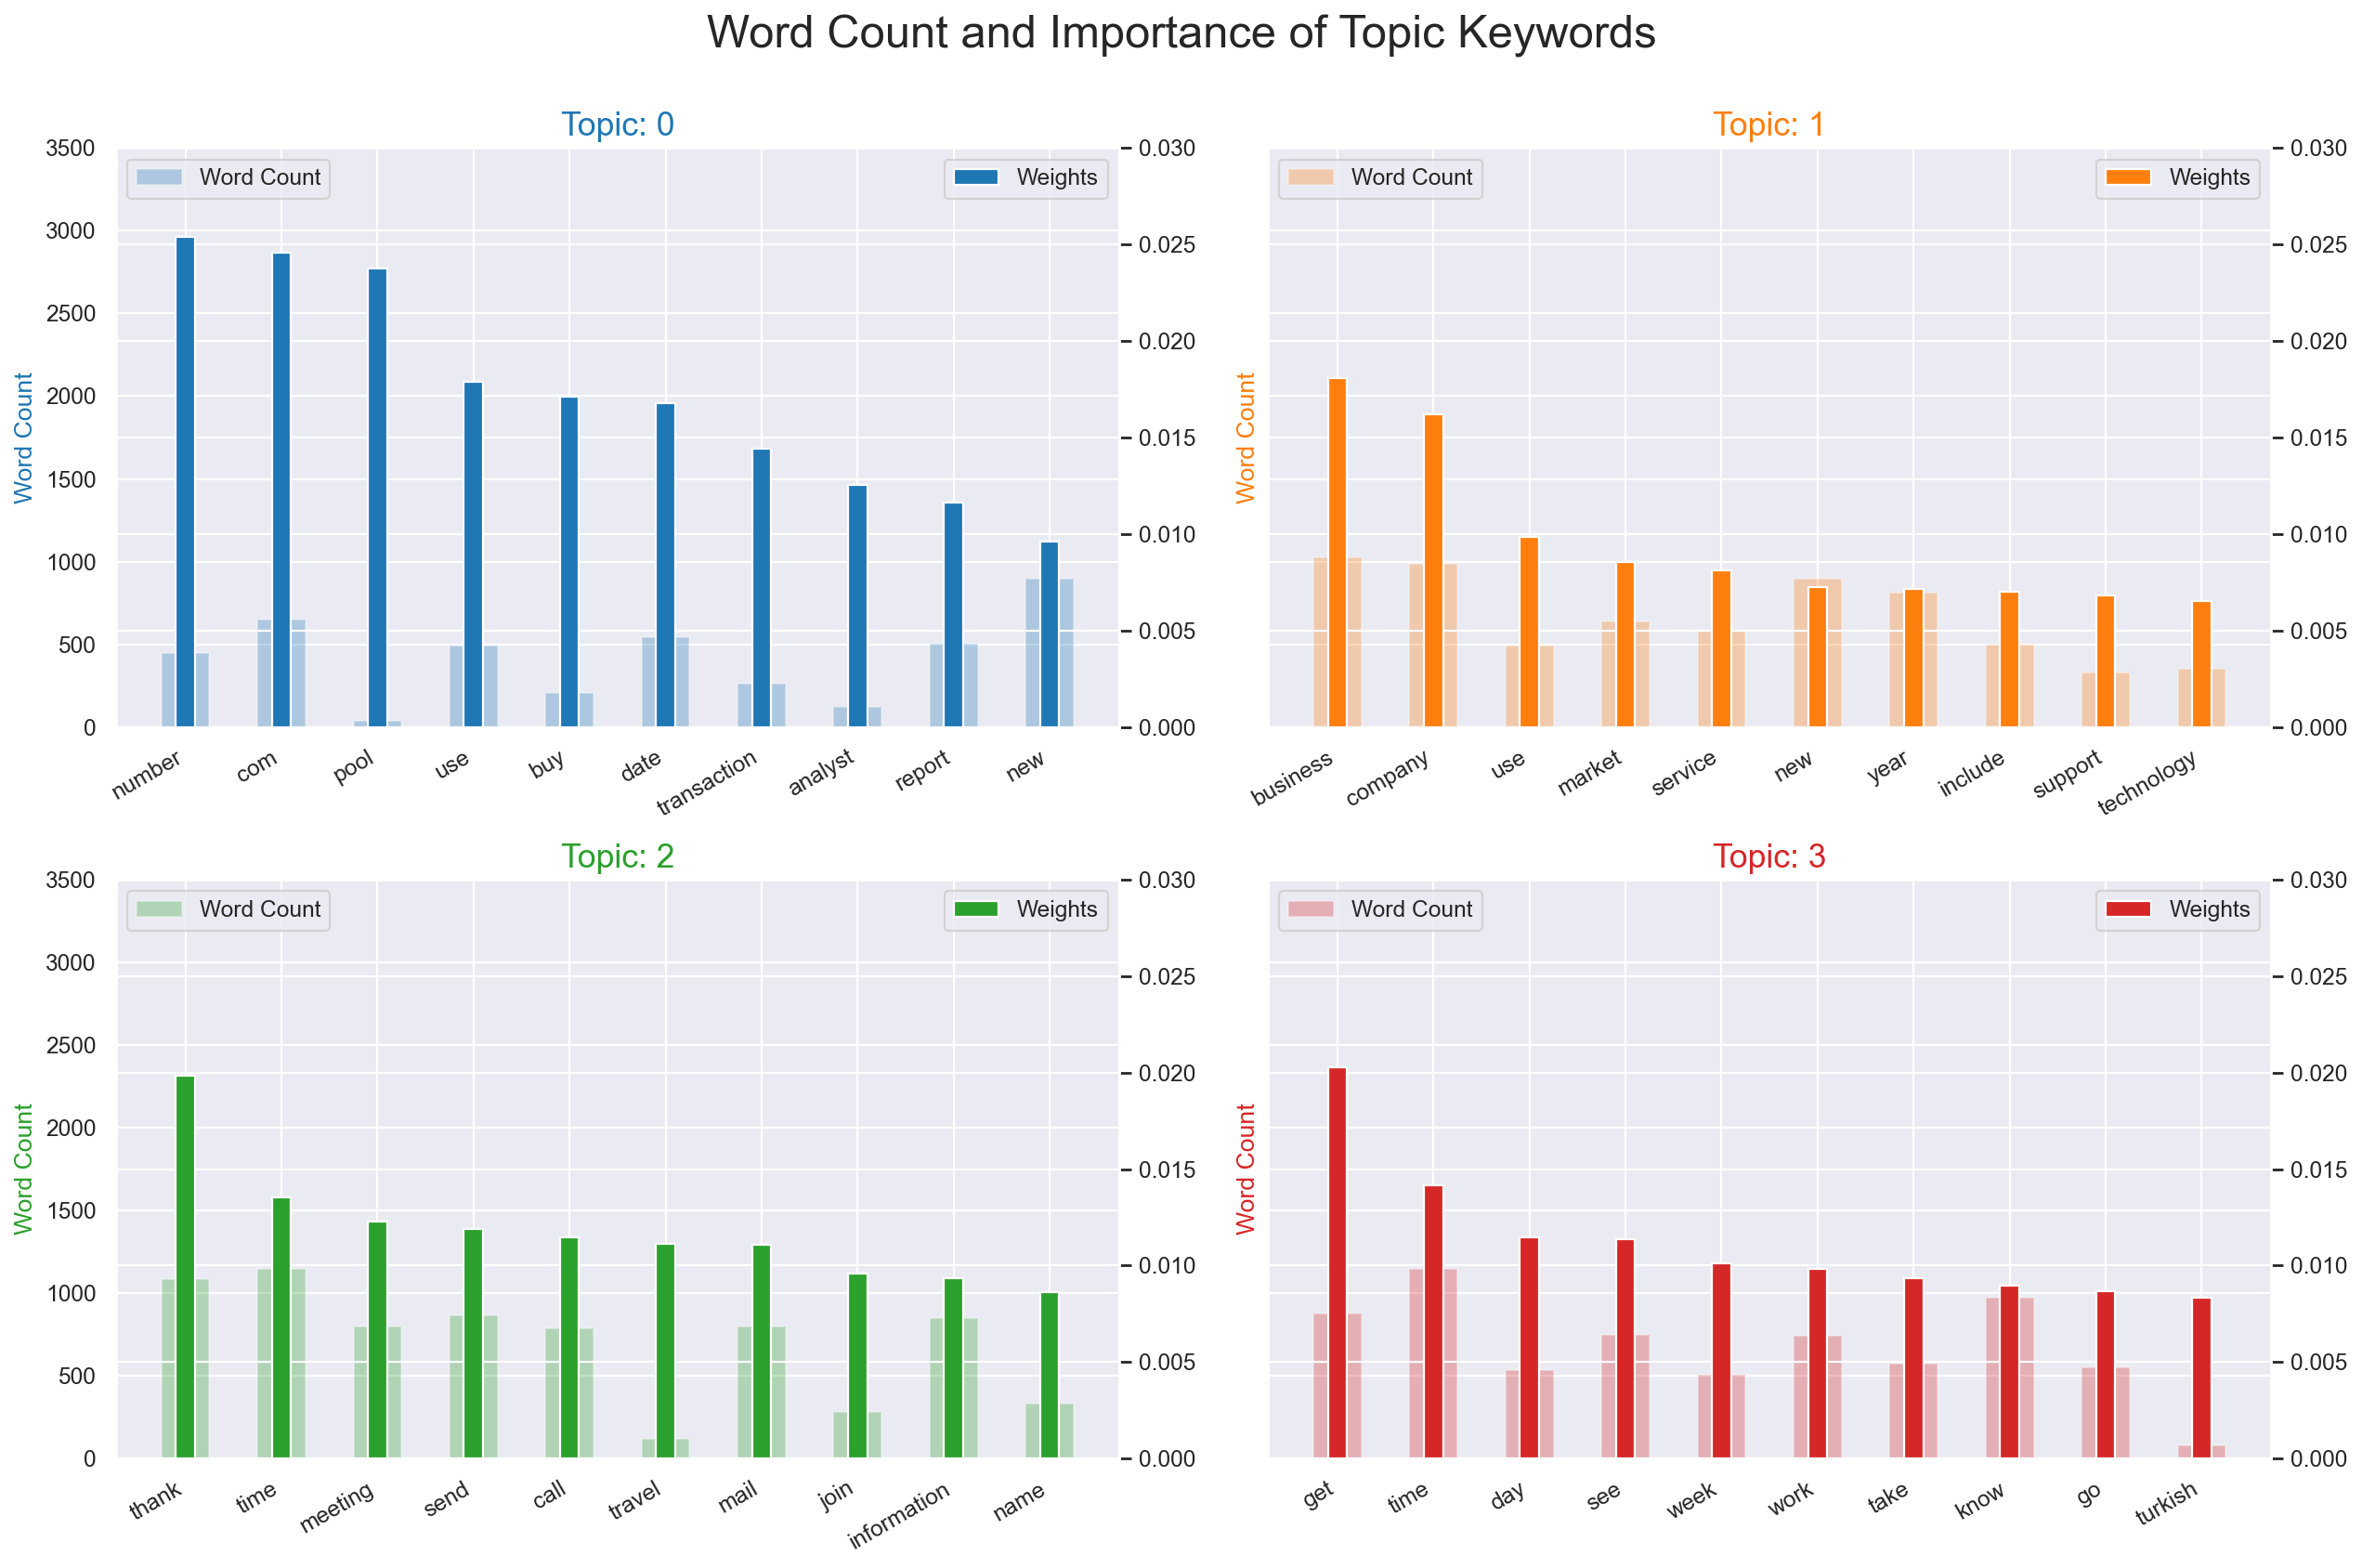

In [44]:
from collections import Counter

topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i, weight, counter[word]])

df = pd.DataFrame(out, columns=["word", "topic_id", "importance", "word_count"])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(
        x="word",
        height="word_count",
        data=df.loc[df.topic_id == i, :],
        color=cols[i],
        width=0.5,
        alpha=0.3,
        label="Word Count",
    )
    ax_twin = ax.twinx()
    ax_twin.bar(
        x="word",
        height="importance",
        data=df.loc[df.topic_id == i, :],
        color=cols[i],
        width=0.2,
        label="Weights",
    )
    ax.set_ylabel("Word Count", color=cols[i])
    ax_twin.set_ylim(0, 0.030)
    ax.set_ylim(0, 3500)
    ax.set_title("Topic: " + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis="y", left=False)
    ax.set_xticklabels(
        df.loc[df.topic_id == i, "word"], rotation=30, horizontalalignment="right"
    )
    ax.legend(loc="upper left")
    ax_twin.legend(loc="upper right")

fig.tight_layout(w_pad=2)
fig.suptitle("Word Count and Importance of Topic Keywords", fontsize=22, y=1.05)
plt.show()


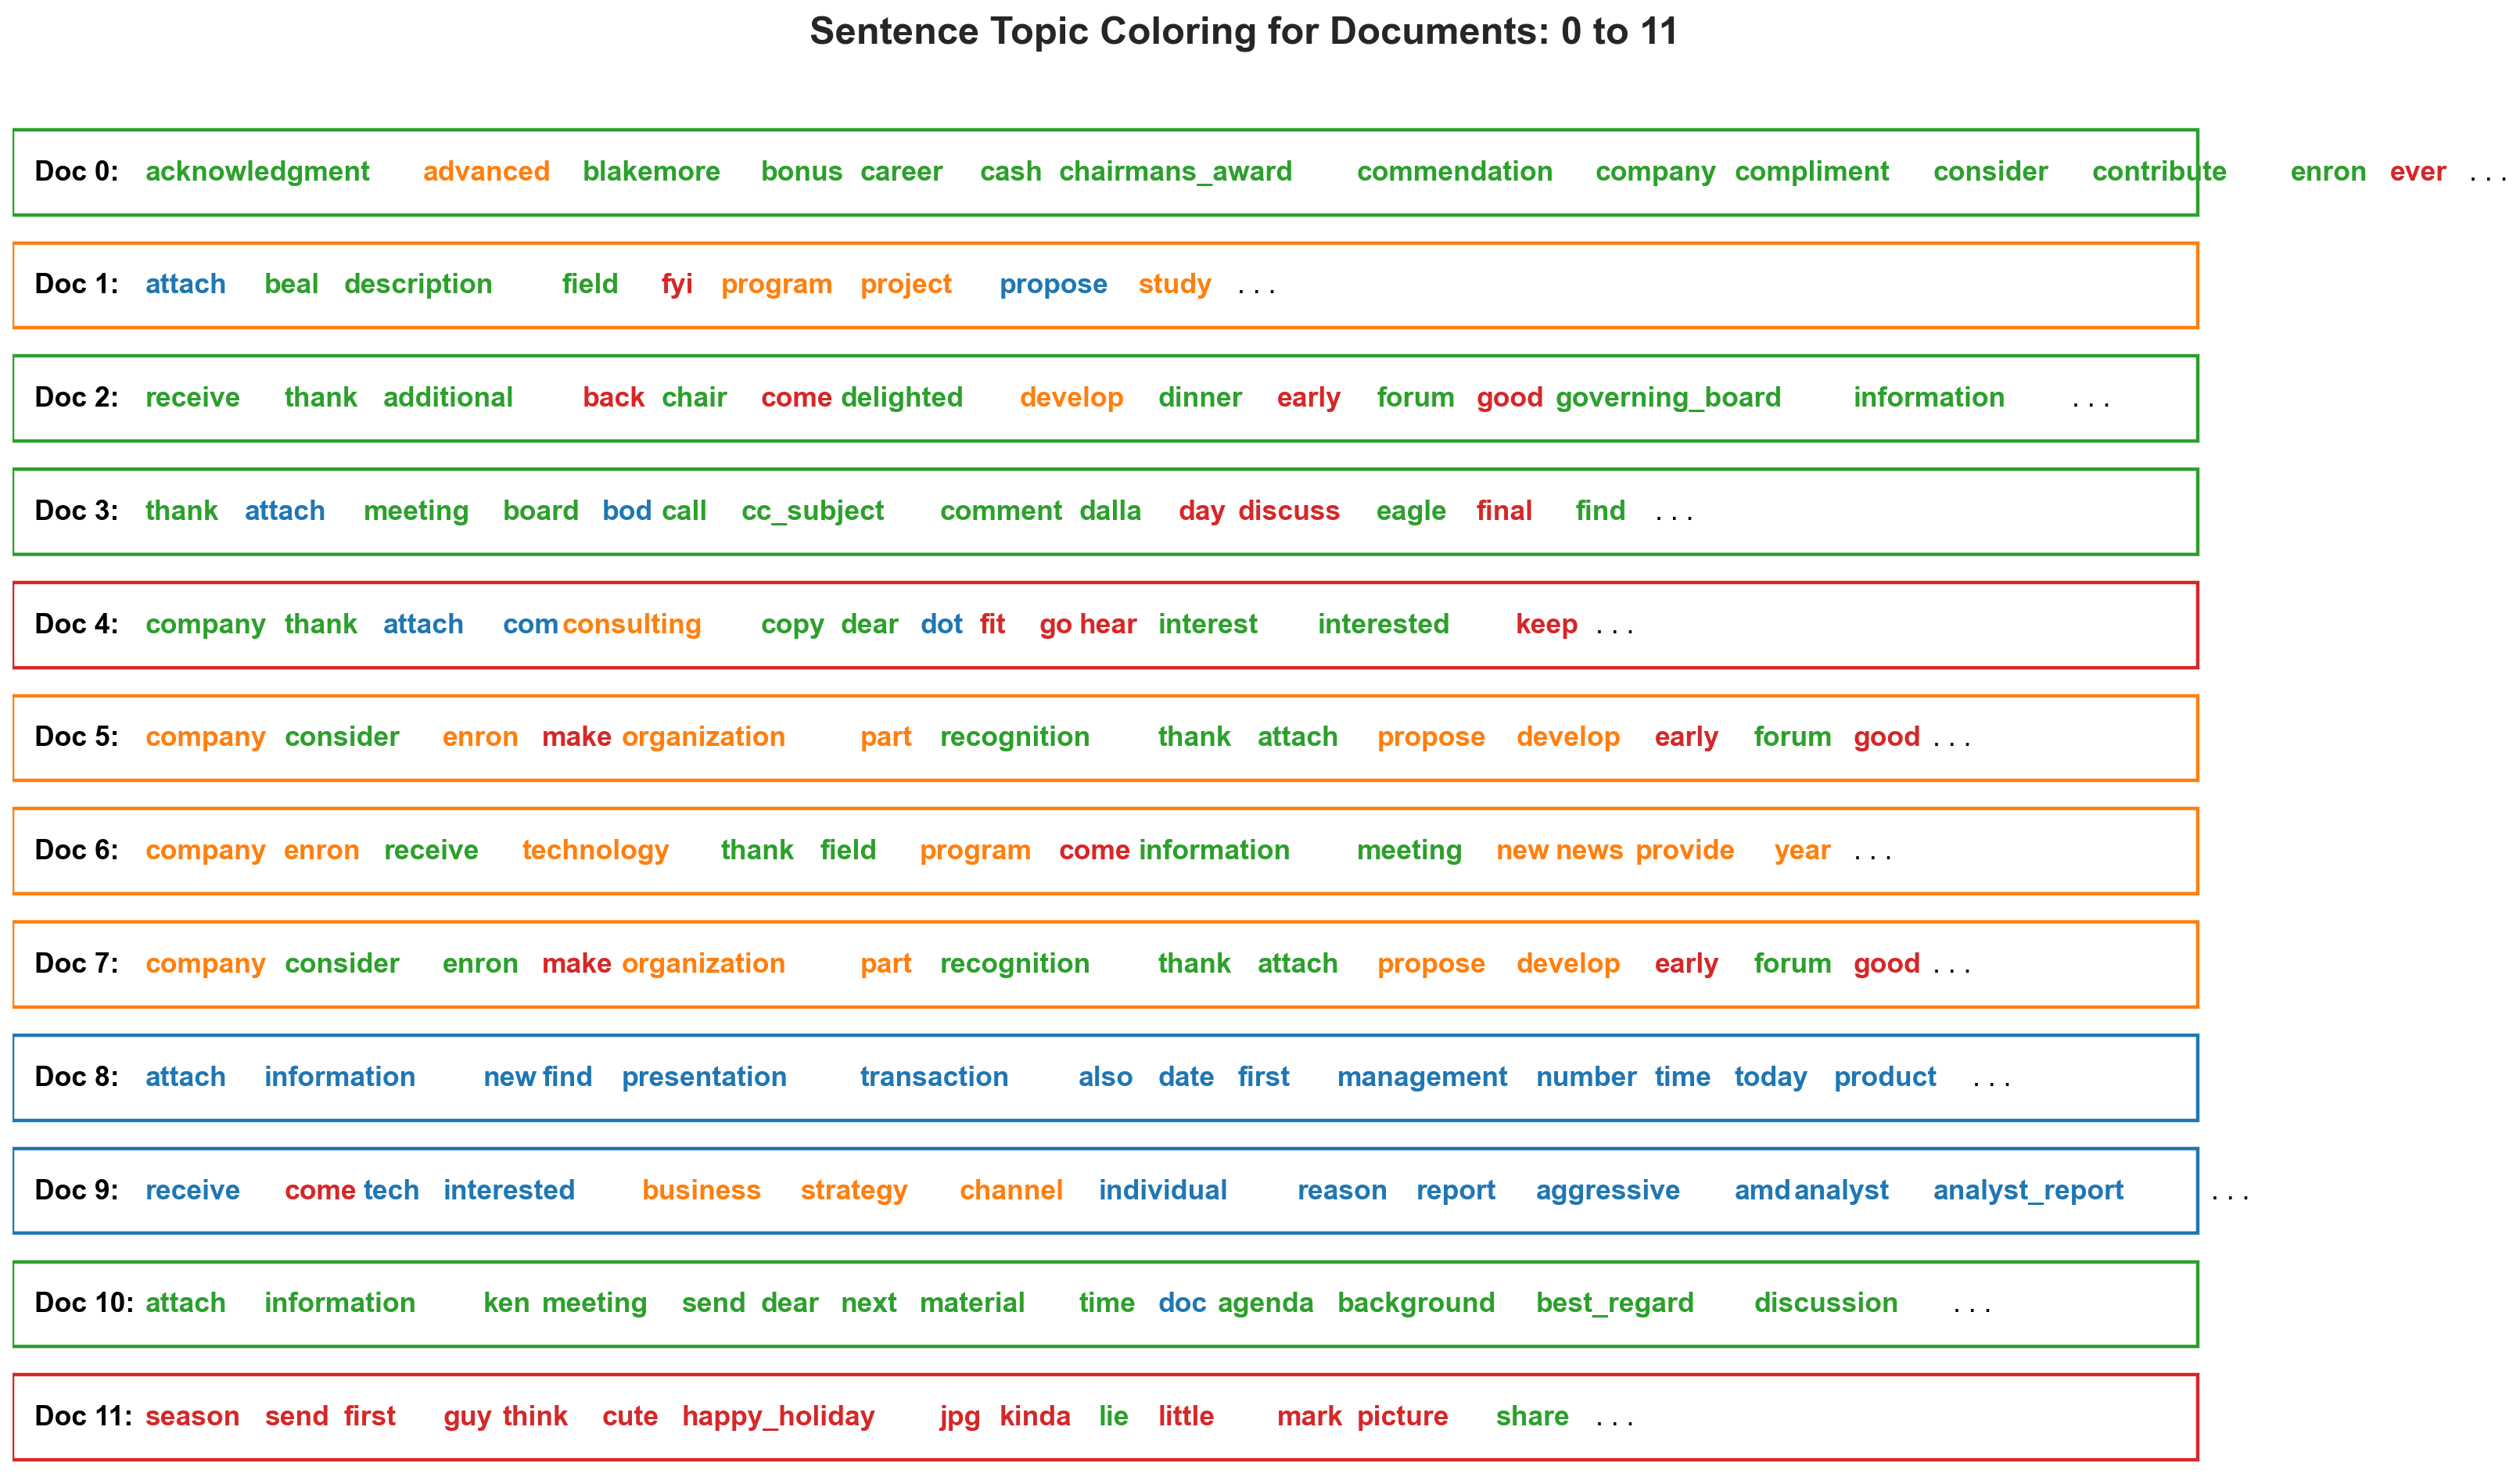

In [45]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle


def sentences_chart(lda_model=lda_model, corpus=corpus, start=0, end=13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(
        end - start, 1, figsize=(20, (end - start) * 0.95), dpi=160
    )
    axes[0].axis("off")
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i - 1]
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [
                (lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics
            ]
            ax.text(
                0.01,
                0.5,
                "Doc " + str(i - 1) + ": ",
                verticalalignment="center",
                fontsize=16,
                color="black",
                transform=ax.transAxes,
                fontweight=700,
            )

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(
                Rectangle(
                    (0.0, 0.05),
                    0.99,
                    0.90,
                    fill=None,
                    alpha=1,
                    color=mycolors[topic_percs_sorted[0][0]],
                    linewidth=2,
                )
            )

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(
                        word_pos,
                        0.5,
                        word,
                        horizontalalignment="left",
                        verticalalignment="center",
                        fontsize=16,
                        color=mycolors[topics],
                        transform=ax.transAxes,
                        fontweight=700,
                    )
                    word_pos += 0.009 * len(word)  # to move the word for the next iter
                    ax.axis("off")
            ax.text(
                word_pos,
                0.5,
                ". . .",
                horizontalalignment="left",
                verticalalignment="center",
                fontsize=16,
                color="black",
                transform=ax.transAxes,
            )

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle(
        "Sentence Topic Coloring for Documents: " + str(start) + " to " + str(end - 2),
        fontsize=22,
        y=0.95,
        fontweight=700,
    )
    plt.tight_layout()
    plt.show()


sentences_chart()


### Impliment K Means Cluster Algorithm


In [72]:
true_k = 5
model = KMeans(n_clusters=true_k, init="k-means++", max_iter=300, n_init=1, verbose=1)
model.fit(X_df)


Initialization complete
Iteration 0, inertia 748539.0
Iteration 1, inertia 639526.4353756751
Iteration 2, inertia 625511.0329352162
Iteration 3, inertia 612133.717514022
Iteration 4, inertia 610952.4145894797
Iteration 5, inertia 610928.7678628562
Iteration 6, inertia 610905.5028617488
Iteration 7, inertia 610887.4429449111
Iteration 8, inertia 610877.7829570213
Converged at iteration 8: strict convergence.


KMeans(n_clusters=5, n_init=1, verbose=1)

In [73]:
from joblib import dump, load

dump(model, "model.joblib")


['model.joblib']

In [74]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = cv.get_feature_names()


C:\Users\sayra\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [75]:
order_centroids


array([[ 206, 1884,  795, ..., 1556, 1099,  883],
       [ 323, 1522, 1166, ..., 1161, 1152,    0],
       [ 219, 1879,  537, ..., 1770,  206,  543],
       [ 537,  795, 1884, ...,  929,  928,    0],
       [ 883, 1879,  543, ...,   55,  966,  969]], dtype=int64)

In [76]:
model.cluster_centers_.argsort()


array([[ 883, 1099, 1556, ...,  795, 1884,  206],
       [   0, 1152, 1161, ..., 1166, 1522,  323],
       [ 543,  206, 1770, ...,  537, 1879,  219],
       [   0,  928,  929, ..., 1884,  795,  537],
       [ 969,  966,   55, ...,  543, 1879,  883]], dtype=int64)

### Feature Words Per Cluster

https://github.com/adriancampos1/Enron_Email_Analysis/blob/master/Enron_Email_Analysis_K-means_clustering.ipynb


In [77]:
for i in range(true_k):
    print("Cluster d:", i),
    for ind in order_centroids[i, :20]:
        print(" ", terms[ind])


Cluster d: 0
  areas
  unsubscribe
  garza
  customer
  garten
  21
  mind
  officer
  means
  bringing
  speakers
  events
  currency
  reported
  three
  overview
  appears
  34
  man
  grumbles
Cluster d: 1
  bureau
  require
  mena
  ceo
  know
  exclusive
  managed
  leave
  garza
  asked
  previous
  system
  bob
  man
  needed
  password
  generation
  nice
  roman
  grumbles
Cluster d: 2
  asked
  unit
  december
  unsubscribe
  garza
  man
  horton
  metals
  telecom
  grumbles
  opportunity
  funds
  larry
  stanley
  3rd
  regarding
  bulletin
  know
  outside
  government
Cluster d: 3
  december
  garza
  unsubscribe
  managed
  mind
  man
  dallas
  account
  gary
  35
  system
  unfoundation
  asp
  garten
  lay
  bob
  fax
  grumbles
  metals
  culture
Cluster d: 4
  horton
  unit
  delay
  informal
  stanley
  leaders
  man
  income
  rockets
  telecom
  build
  grumbles
  importance
  asked
  investment
  specifically
  larry
  associated
  funds
  dabhol


### Run Test Document & Find it's Cluster


In [78]:
# confirming we still have our 'body' document
test_document = df["body"][0]
test_document


"Gentlemen,\n\nThank you for the letter memorializing my nomination for the 2000 Chairman's \nAward.  It is a privilege to be a part of the Enron organization.  I have \nreceived many promotions, cash bonuses and commendations during my career but \nI consider the recognition as a nominee for the 2000 Chairman's Award to be \nthe most significant acknowledgment of my performance ever received.  My \ncompliments to you for making Enron one of the most successful and excellent \ncompanies on the globe.  I only wish that I could contribute more to Enron's \ngrowth and continued success.\n\nSincerely,\n\nRW Blakemore\nEnron Wind Energy Systems Corp.\nCenter For Advanced Technology "

In [79]:
test_X = cv.transform([test_document])
test_X_dense = test_X.todense()


In [80]:
text_X_df = pd.DataFrame(test_X_dense, columns=cv.get_feature_names())
# creating new dense to correct for chopped of features earlier


In [81]:
text_X_df = text_X_df.iloc[:, 106:]


In [82]:
text_X_df.head(5)


,accept,accepted,access,according,account,accounting,accounts,achieve,acquisition,across,act,action,active,activities,activity,actually,ad,add,added,addition,additional,address,addressee,administration,advance,advanced,advantage,adventis,advertising,advise,advised,advisory,advlaser,aei,affairs,africa,afternoon,agency,agenda,agent,ago,agree,agreed,agreement,agreements,ahead,aid,air,ajunto,al,alert,alliance,allow,almost,along,alphaserver,already,also,although,alumni,always,amelia,america,american,americas,among,amount,analysis,analyst,analysts,anderson,andrew,angeles,ann,announce,announced,announcement,announcements,annual,another,answer,anti,anyone,anything,aol,apparently,appear,appears,application,applications,appointment,appreciate,appreciated,approach,appropriate,approval,approved,approximately,april,area,areas,arena,around,arrange,arrangements,arrive,art,arthur,article,articles,ase,asia,ask,asked,asking,asp,aspen,assessment,asset,assets,assist,assistance,assistant,associate,associated,associates,association,assume,att,attachment,attachments,attend,attendance,attendees,attending,attention,audience,august,austin,author,authority,availability,available,avenue,average,avg,award,awards,aware,away,azurix,back,background,bad,bandwidth,bank,barbara,base,based,basis,baxter,beach,beat,beautiful,become,becoming,beek,begin,beginning,behalf,behind,believe,ben,benefit,benefits,benson,best,beta,betas,better,beyond,bhatnagar,bibi,bid,big,bill,billion,bio,bit,black,board,bob,body,book,boston,box,bradley,breakfast,brian,bridge,brief,briefing,bring,bringing,broad,broadband,brookings,brother,brothers,brought,brown,bruce,budget,build,building,built,bulletin,bureau,bush,business,businesses,businessweek,busy,buy,buying,buys,ca,cable,calendar,california,call,called,calls,came,campaign,canada,candidate,candidates,cannot,capacity,capital,car,card,care,career,carol,case,cash,causey,cdt,...,suggestions,suite,summary,summer,summit,sun,sunday,supply,support,supporting,sure,survey,susan,sutton,system,systems,table,take,taken,takes,taking,talk,talked,talking,target,task,tax,teaching,team,teams,tech,technical,technologies,technology,tel,telecom,telephone,tell,ten,term,terms,test,texas,text,tfa,th,thank,thanks,therefore,thing,things,think,thinking,third,thomas,thompson,though,thought,thoughts,three,throughout,thursday,thus,ticket,tickets,tii,tim,time,times,today,together,told,tom,tomorrow,tony,took,tools,top,topic,topics,tori,total,touch,tour,tournament,toward,towbin,town,track,trade,trading,trailing,training,trans,transacted,transacting,transaction,transactions,transfer,transition,transmission,transportation,travel,traveling,tremendous,trip,true,truly,trust,try,trying,tuesday,turkey,turkish,turn,tv,two,tx,type,uh,uk,un,unable,understand,understanding,unfortunately,unfoundation,union,unique,unit,united,units,university,unless,unsubscribe,unterberg,unwire,upcoming,update,updates,upon,us,usa,uschamber,use,used,user,users,usibc,using,utilities,utility,vacation,valley,value,vanessa,various,venture,ventures,verizon,version,via,vice,video,view,views,vision,visit,vod,voice,volume,vote,vp,vs,wade,walk,walker,wall,want,wanted,wants,war,washington,watch,water,way,ways,weather,web,website,wed,wedding,wednesday,week,weekend,weekly,weeks,welcome,well,wells,went,west,whalley,whether,white,whole,wholesale,wife,william,williams,williamson,willing,win,wind,windows,wins,winter,wire,wireless,wish,wishes,within,without,women,wonderful,woody,word,words,work,worked,working,works,world,worldwide,worth,would,write,writing,written,wrote,www,xls,yahoo,years,yes,yesterday,yet,york,young,ypo
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [83]:
print("Prediction")
predicted = model.predict(text_X_df)
print(predicted)


Prediction
[4]


### Plot cluster


In [84]:
model.cluster_centers_.shape


(5, 1894)

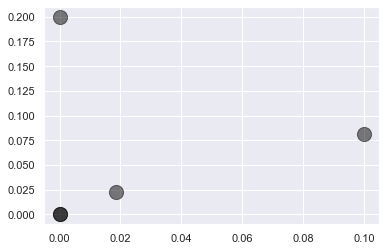

In [85]:
centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c="black", s=200, alpha=0.5)


C:\Users\sayra\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


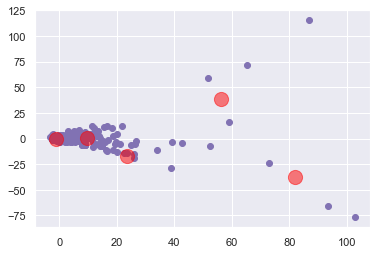

In [86]:
pca = PCA(n_components=2)
coords = pca.fit_transform(X_df)

centers = model.cluster_centers_
pca_centers = pca.transform(centers)

plt.scatter(coords[:, 0], coords[:, 1], c="m")
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], c="red", s=200, alpha=0.5)
plt.show()


In [87]:
pca.transform(model.cluster_centers_)


C:\Users\sayra\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


array([[ 2.36350743e+01, -1.69884201e+01],
       [ 5.63557682e+01,  3.87786830e+01],
       [ 9.50356253e+00,  8.95384417e-01],
       [ 8.20114955e+01, -3.76093254e+01],
       [-9.96594685e-01, -5.21704693e-02]])